<a href="https://colab.research.google.com/github/elpinchepastel/Hyperspectral-Remote-Sensing-Scenes/blob/master/Indian%20Pines/Indian%20Pines%20SRP%20%2B%20SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Hyperspectral Image Reduction**

This project is structured so:

1. Import necessary libraries

2. Download dataset Indian Pines (Correct and gt)

3. Review of dataset structure and loading

4. Visualizing ground truth

5. Visualizing the bands of the Correct

6. Extract pixels and class from the dataset, preparing the data for reduction

7. Dimensionality Reduction (SRP)

8. Classify by support vector machine (SVM)


## **1. Import necessary libraries**

In [1]:
%%time
!pip install spectral
!pip install tqdm

     |████████████████████████████████| 215kB 6.8MB/s 
CPU times: user 19.8 ms, sys: 20.2 ms, total: 40 ms
Wall time: 6.95 s


In [2]:
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import random
import scipy.io
import scipy.io as sio
import seaborn as sns
import spectral

from IPython.display import Image
from matplotlib.legend_handler import HandlerLine2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import loadmat
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tqdm import tqdm

sns.axes_style('whitegrid');

# **2. Download dataset Indian Pines (Correct and gt)**

In [3]:
%%time
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"
!wget "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"

--2020-10-22 09:41:11--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M) [text/plain]
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  2.08MB/s    in 2.7s    

2020-10-22 09:41:14 (2.08 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2020-10-22 09:41:14--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K) [text/plain]
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2020-10-22 09:41:14 (169 MB/s) - ‘Indian_pines_gt

In [4]:
# Verify that the ".mat" type dataset is downloaded locally
!ls

Indian_pines_corrected.mat  Indian_pines_gt.mat  sample_data


## **3. Review of dataset structure and loading**

In [5]:
# Data types for the dataset
correct = loadmat('Indian_pines_corrected.mat')
gt = loadmat('Indian_pines_gt.mat')
print(type(correct))
print(type(gt))

<class 'dict'>
<class 'dict'>


In [6]:
# The keys of the dictionary
print(f'Dictionary Indian Pines Correct: {correct.keys()}\nDictionary Indian Pines Ground truth: {gt.keys()}')

Dictionary Indian Pines Correct: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])
Dictionary Indian Pines Ground truth: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])


In [7]:
# Read the dataset
def dataset(correct, gt):
  dataset_correct = scipy.io.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  dataset_gt = scipy.io.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  return dataset_correct, dataset_gt

In [8]:
dataset_correct, dataset_gt = dataset(correct, gt)
print(f'Correct: {dataset_correct.shape}\nGround Truth: {dataset_gt.shape}')

Correct: (145, 145, 200)
Ground Truth: (145, 145)


In [9]:
print(type(dataset_correct))
print(type(dataset_gt))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
dict_category = {}
for i in range(dataset_gt.shape[0]):
    for j in range(dataset_gt.shape[1]):
         if dataset_gt[i][j] in [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
            if dataset_gt[i][j] not in dict_category:
                dict_category[dataset_gt[i][j]]=0
            dict_category[dataset_gt[i][j]] +=1
            
sortedDict = sorted(dict_category.items())
print(sortedDict)

[(0, 10776), (1, 46), (2, 1428), (3, 830), (4, 237), (5, 483), (6, 730), (7, 28), (8, 478), (9, 20), (10, 972), (11, 2455), (12, 593), (13, 205), (14, 1265), (15, 386), (16, 93)]


## **4. Visualizing ground truth**

In [11]:
# Colors and names for each category in the dataset
def colors_names():
  gt_color = np.array([
                      [255,   255,    255], #Backgroud
                      [0,     0,      191], #Alfalfa
                      [0,     0,      255], #Corn-notill
                      [0,     64,     255], #Corn-mintill
                      [0,     191,    255], #Corn
                      [0,     255,    255], #Grass-pasture
                      [0  ,   255,    191], #Grass-trees
                      [64,    255,    191], #Grass-pasture-mowed
                      [128,   255,    128], #Hay-windrowed
                      [191,   255,    64],  #Oats
                      [255,   255,    0],   #Soybean-notill
                      [255,   191,    0],   #Soybean-mintill
                      [255,   128,    0],   #Soybean-clean
                      [255,   64,     0],   #Wheat
                      [255,   0,      0],   #Woods
                      [191,   0,      0],   #Buildings-Grass-Trees-Drives
                      [128,   0,      0],   #Stone-Steel-Towers
                       ])
  indianpines_class_names = [
                            'Background',
                            'Alfalfa',
                            'Corn-notill',
                            'Corn-min',
                            'Corn',
                            'Grass/pasture',
                            'Grass/trees',
                            'Grass/pasture-mowed',
                            'Hay-windrowed',
                            'Oats',
                            'Soybeans-notill',
                            'Soybeans-min',
                            'Soybean-clean',
                            'Wheat',
                            'Woods',
                            'Bldg-grass-tree-drives',
                            'Stone-steel towers'
                            ]
  gt_color_eventplot = gt_color/255
  return gt_color, gt_color_eventplot, indianpines_class_names

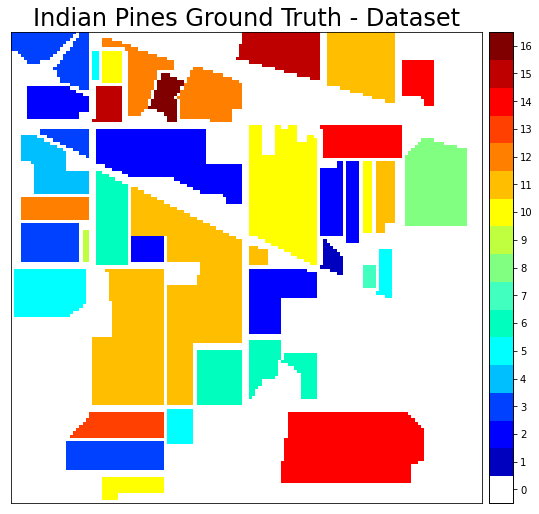

In [12]:
# Display of the "Ground truth" image
gt_color, gt_color_eventplot, indianpines_class_names = colors_names()
ground_truth = spectral.imshow(classes = dataset_gt.astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.title('Indian Pines Ground Truth - Dataset', fontsize=24)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(cax=cax)
plt.colorbar(ticks= range(0,17), cax=cax)
plt.savefig('Indian Pines Ground Truth.TIF')

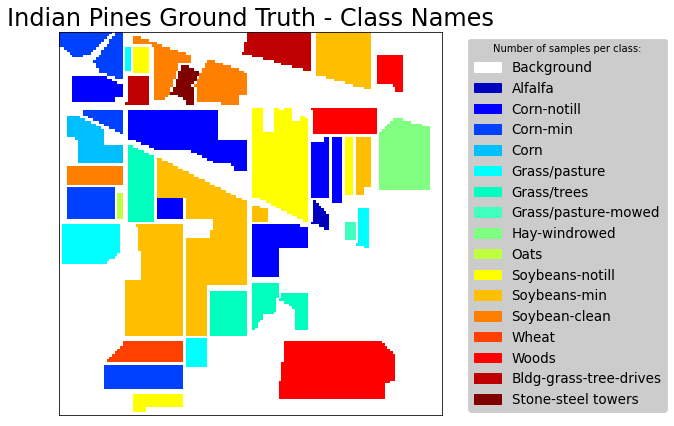

In [13]:
ground_truth = spectral.imshow(classes = dataset_gt.astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.title('Indian Pines Ground Truth - Class Names', fontsize=24)
patches = [mpatches.Patch(color=gt_color_eventplot[i], label=indianpines_class_names[i]) for i in range(len(gt_color_eventplot))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc='upper left', facecolor='silver', fontsize=13.5, title="Number of samples per class:")
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.savefig('Samples and number Indian Pines Ground Truth.TIF')

## **5. Visualizing the bands of the Hyperspectral Correct**

Enter the band number of the image you want to view (The number to be between 0 and 199): 
20


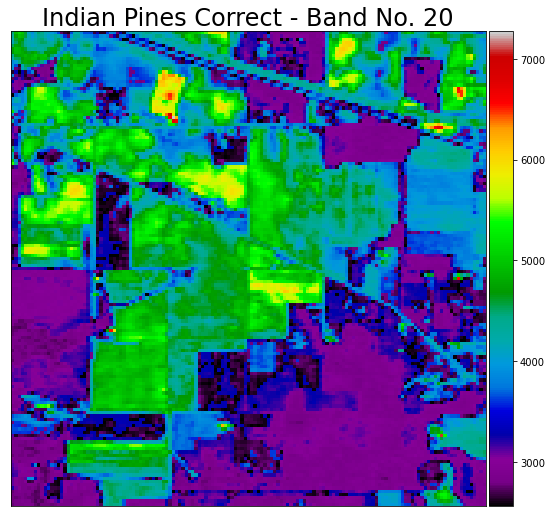

In [14]:
# Display of the "Correct" image on one band

print('Enter the band number of the image you want to view (The number to be between 0 and 199): ')
band = int(input())
one_band = dataset_correct[:, :, band]
plt.figure(figsize=(9, 9))
plt.imshow(one_band, cmap = "nipy_spectral")
plt.title(f'Indian Pines Correct - Band No. {band}', fontsize=24)
plt.xticks([])
plt.yticks([])
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)
plt.savefig(f'Indian Pines Correct - Band No. {band}.TIF')

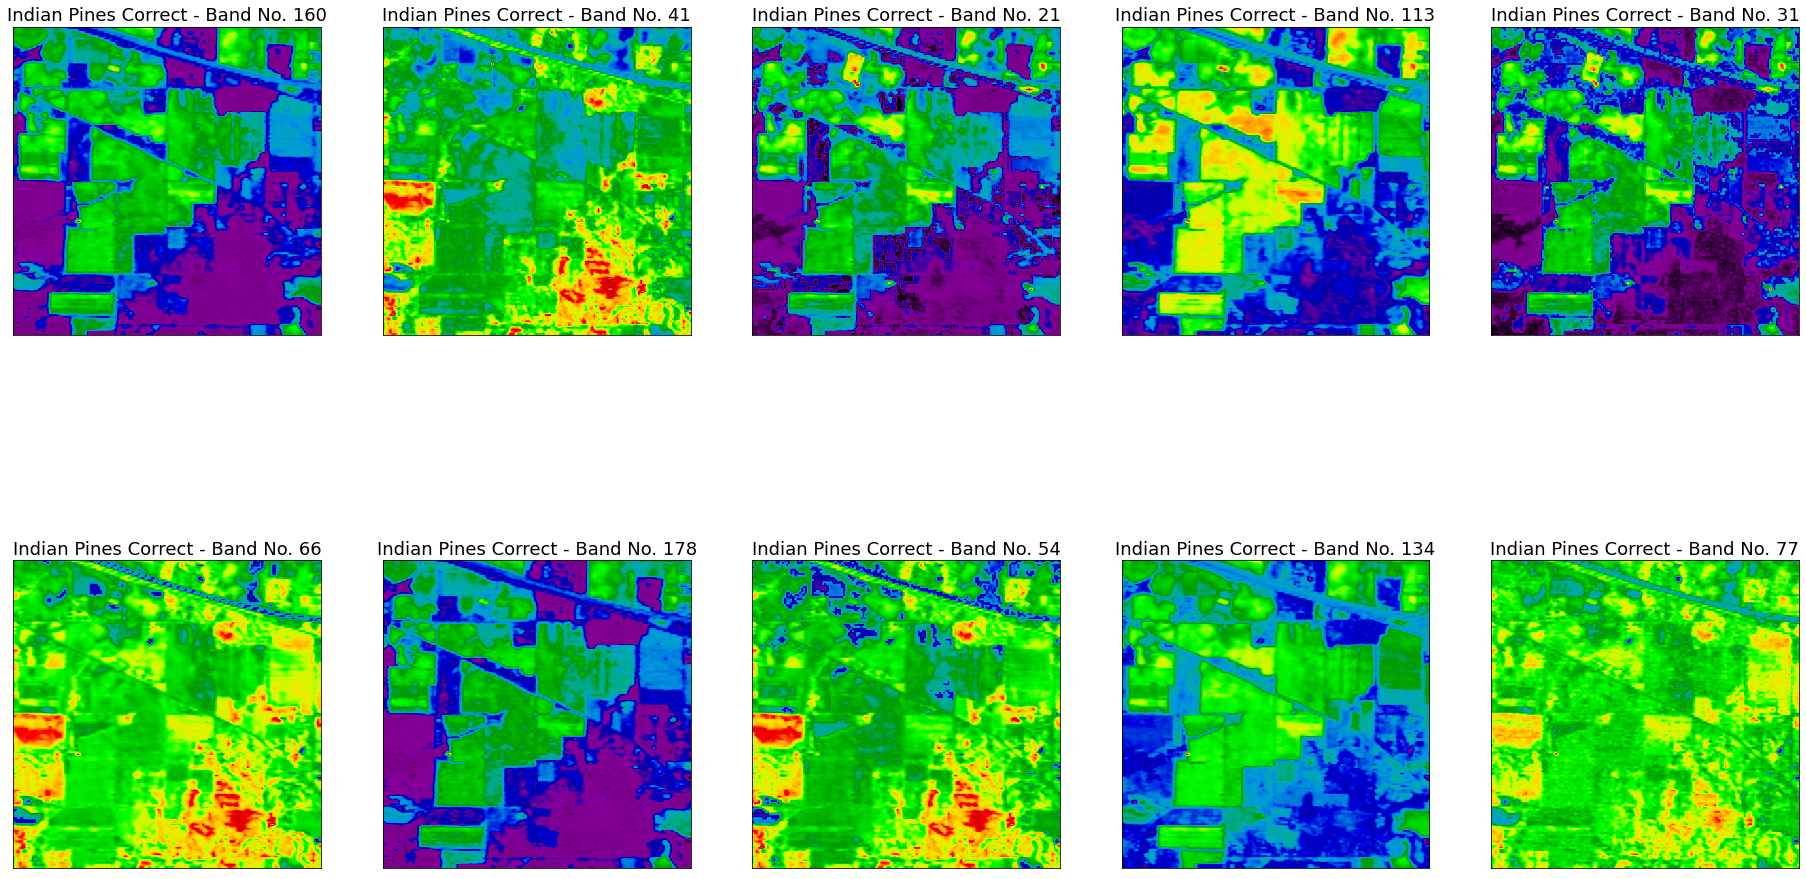

In [15]:
# Display of the "Correct" image on one band random
fig=plt.figure(figsize=(32, 18))
columns = 5
rows = 2
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    band_aleatory = random.randrange(199)
    one_band = dataset_correct[:, :, band_aleatory]
    plt.imshow(one_band, cmap = "nipy_spectral")
    plt.title(f'Indian Pines Correct - Band No. {band_aleatory}', fontsize=18)
    plt.xticks([])
    plt.yticks([])
plt.savefig('Indian Pines Correct - Teen Band Aleatory.TIF')

## **6.  Extract pixels and class from the dataset, preparing the data for reduction**

In [16]:
# Extract pixels and class labels from hyperspectral image correct
def extract_pixels(dataset_correct, dataset_gt):
    df = pd.DataFrame()
    for i in tqdm(range(dataset_correct.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset_correct[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(dataset_gt.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset_correct.shape[2])]+['class']
    return df
df = extract_pixels(dataset_correct, dataset_gt)

100%|██████████| 200/200 [00:00<00:00, 279.38it/s]


In [17]:
# Print and save data
df.to_csv('Dataset.csv', index=False)
df.head()

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,band-11,band-12,band-13,band-14,band-15,band-16,band-17,band-18,band-19,band-20,band-21,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,band-31,band-32,band-33,band-34,band-35,band-36,band-37,band-38,band-39,band-40,...,band-162,band-163,band-164,band-165,band-166,band-167,band-168,band-169,band-170,band-171,band-172,band-173,band-174,band-175,band-176,band-177,band-178,band-179,band-180,band-181,band-182,band-183,band-184,band-185,band-186,band-187,band-188,band-189,band-190,band-191,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,4816,4769,4610,4805,4828,4861,4767,4624,4549,4463,4462,4446,4445,4336,4381,4319,4207,4305,4311,3991,4168,3942,4061,4362,4318,4252,4869,5284,5055,3591,...,1396,1381,1396,1381,1353,1346,1341,1332,1324,1310,1318,1330,1310,1292,1280,1275,1266,1264,1233,1241,1232,1215,1215,1187,1168,1171,1150,1134,1123,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,5141,5100,4994,5172,5290,5289,5217,5053,5033,4939,4931,4941,4902,4824,4859,4805,4698,4794,4806,4452,4628,4433,4643,4967,4853,4760,5449,5768,5684,3987,...,1421,1415,1428,1415,1379,1370,1360,1353,1352,1336,1346,1351,1330,1315,1305,1292,1282,1286,1259,1259,1250,1229,1232,1195,1177,1184,1153,1137,1138,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,5227,5172,5097,5313,5411,5412,5341,5191,5140,5069,5110,5119,5046,4981,5023,4987,4862,4965,4992,4595,4756,4529,4801,5077,4983,4868,5515,5972,5913,4027,...,1446,1440,1443,1425,1390,1379,1376,1363,1355,1347,1361,1356,1341,1330,1321,1304,1290,1289,1263,1269,1261,1245,1241,1214,1185,1188,1156,1147,1149,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,5147,5078,5040,5237,5321,5344,5255,5121,5035,4956,4994,4980,4905,4857,4900,4831,4720,4848,4847,4484,4613,4402,4674,4966,4848,4776,5473,5894,5789,4086,...,1432,1427,1426,1416,1386,1374,1375,1359,1343,1343,1354,1351,1333,1329,1313,1296,1280,1281,1251,1255,1253,1238,1223,1207,1188,1188,1154,1143,1144,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,4853,4857,4734,4879,4976,4958,4885,4754,4647,4532,4586,4591,4492,4453,4497,4398,4297,4408,4401,4102,4227,4075,4264,4529,4490,4438,5001,5378,5321,3779,...,1401,1397,1395,1390,1368,1349,1354,1340,1330,1324,1336,1332,1320,1307,1287,1283,1267,1265,1239,1240,1239,1229,1212,1202,1178,1178,1143,1135,1138,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [18]:
# Verify the save data locally
!ls

 Dataset.csv
'Indian Pines Correct - Band No. 20.TIF'
 Indian_pines_corrected.mat
'Indian Pines Correct - Teen Band Aleatory.TIF'
'Indian Pines Ground Truth.TIF'
 Indian_pines_gt.mat
 sample_data
'Samples and number Indian Pines Ground Truth.TIF'


In [19]:
# Indexation of 145 x 145 of the first two components
def indexation(dataset_correct, dataset_gt):
  dataset_correct = df.iloc[:, :-1].values
  dataset_gt = df.iloc[:, -1].values
  return dataset_correct, dataset_gt

In [20]:
dataset_correct, dataset_gt = indexation(dataset_correct, dataset_gt)
print(f'Size Indian Pines Correct: {dataset_correct.shape}\nSize Indian Pines Ground truth: {dataset_gt.shape}')

Size Indian Pines Correct: (21025, 200)
Size Indian Pines Ground truth: (21025,)


## **7. Dimensionality Reduction (SRP)**

In [21]:
def method_SRP(n_components):
  SRP = SparseRandomProjection(n_components=n_components,density = 'auto', eps = 0.5, random_state=2019, dense_output = False)
  principalComponents = SRP.fit_transform(dataset_correct)
  return principalComponents
  #print(f"Size Indian Pines Correct Reduced: {principalComponents.shape}")

In [22]:
print("Enter the band number of the image you want to reduce (the number must be less than 199): ")
n_components = int(input())
principalComponents = method_SRP(n_components)
print(f"Size Indian Pines Correct Reduced: {principalComponents.shape}")

Enter the band number of the image you want to reduce (the number must be less than 199): 
150
Size Indian Pines Correct Reduced: (21025, 150)


In [23]:
#Reversal of Indexing
dataset_correct_reduced = np.reshape(principalComponents, (145, 145, n_components))
print(f"Size Indian Pines Correct Reduced: {dataset_correct_reduced.shape}")

Size Indian Pines Correct Reduced: (145, 145, 150)


Enter the band number of the image you want to view (The number to be between 0 and 150): 
20


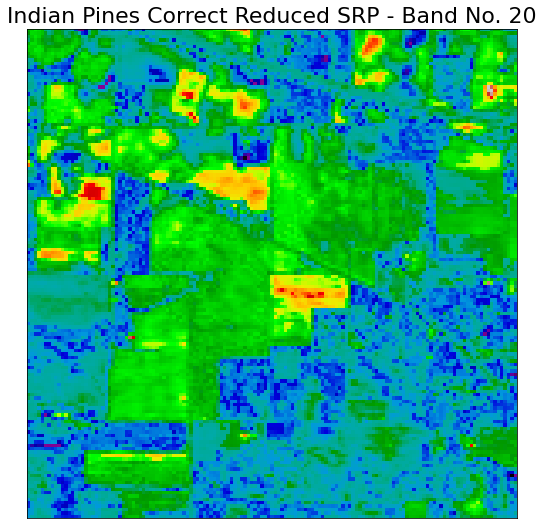

In [24]:
# Display of the "Correct" image on one band
print(f'Enter the band number of the image you want to view (The number to be between 0 and {n_components}): ')
band = int(input())
one_band = dataset_correct_reduced[:, :, band]
plt.figure(figsize=(9, 9))
plt.imshow(one_band, cmap = "nipy_spectral")
plt.title(f'Indian Pines Correct Reduced SRP - Band No. {band}', fontsize=22)
plt.xticks([])
plt.yticks([])
plt.savefig(f'Indian Pines Correct Reduce SRP - Band No. {band}.TIF')

## **8. Classify by support vector machine (SVM)**

In [25]:
# Split the reduced data through training and testing
dataset_correct_train, dataset_correct_test, dataset_gt_train, dataset_gt_test, indices_train, indices_test  = train_test_split(principalComponents, dataset_gt,  range(dataset_correct.shape[0]), 
                                                                                  test_size = 0.20, random_state = 11)

print(f'Dataset Correct Train: {dataset_correct_train.shape}\nDataset Correct Test: {dataset_correct_test.shape}')

Dataset Correct Train: (16820, 150)
Dataset Correct Test: (4205, 150)


In [26]:
def classifier(k):
  if k == "1":
    k = "rbf"
  else:
    if k == "2":
      k = "linear"
    else:
      if k == "3":
        k = "poly"
      else:
        if k == "4":
          k = "sigmoid"
        else:
          print("Select the correct option:")
  return k

In [27]:
# Select a classifier
k = input("Enter a classifier:\nrbf = 1\nlinear = 2\npoly = 3\nsigmoid = 4\n")

Enter a classifier:
rbf = 1
linear = 2
poly = 3
sigmoid = 4
1


In [28]:
# Implementing support vector machine (SVM) using a classifier
%%time
k = classifier(k)
svm = SVC(kernel=k, degree = 10, gamma='scale', cache_size=1024*7)
svm.fit(dataset_correct_train, dataset_gt_train)

CPU times: user 45.2 s, sys: 159 ms, total: 45.4 s
Wall time: 45.4 s


In [29]:
# Gt prediction implementation
dataset_gt_pred = svm.predict(dataset_correct_test)
pre = dataset_gt_pred

clmap = [0]*dataset_correct.shape[0]

for i in tqdm(range(len(indices_train))):
    clmap[indices_train[i]] = dataset_gt[indices_train[i]]

for i in tqdm(range(len(indices_test))):
    clmap[indices_test[i]] = pre[i]

100%|██████████| 4205/4205 [00:00<00:00, 1119031.05it/s]


In [30]:
print(f'Accuracy: {accuracy_score(dataset_gt_test,dataset_gt_pred)}%')

Accuracy: 0.5776456599286564%


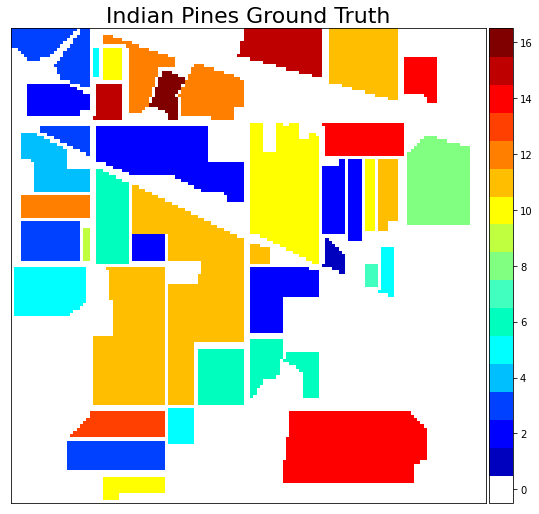

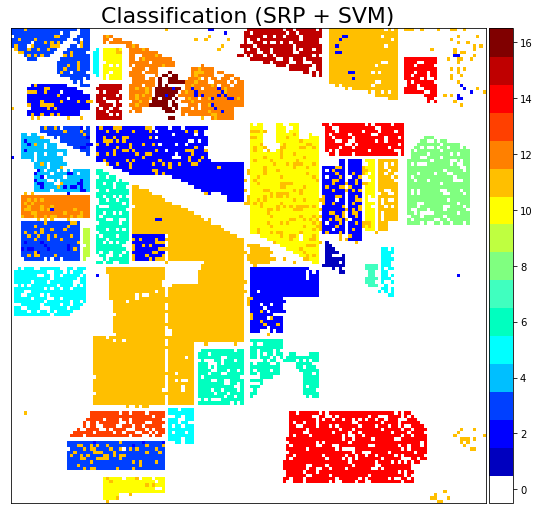

In [31]:
# Displaying the "Indian Pines Ground Truth" and "Indian Pines SRP + SVM"
gt_color, gt_color_eventplot, indianpines_class_names = colors_names()
dataset_correct, dataset_gt = dataset(correct, gt)
dataset_gt = spectral.imshow(classes = dataset_gt.astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Indian Pines Ground Truth', fontsize=22)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)

dataset_gt_svm = spectral.imshow(classes = np.array(clmap).reshape((145, 145)).astype(int), figsize =(9,9),colors=gt_color, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.title('Classification (SRP + SVM)', fontsize=22)
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax=cax)

plt.savefig('Classification (SRP + SVM).TIF')

In [32]:
print('Classification report:\n',classification_report(dataset_gt_test,dataset_gt_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.91      0.76      2156
           1       0.00      0.00      0.00        11
           2       0.44      0.24      0.31       296
           3       0.00      0.00      0.00       160
           4       0.00      0.00      0.00        58
           5       0.00      0.00      0.00        98
           6       0.00      0.00      0.00       159
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00        91
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00       174
          11       0.37      0.83      0.51       471
          12       0.00      0.00      0.00       126
          13       0.00      0.00      0.00        47
          14       0.00      0.00      0.00       239
          15       0.00      0.00      0.00        83
          16       0.00      0.00      0.00        28

  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


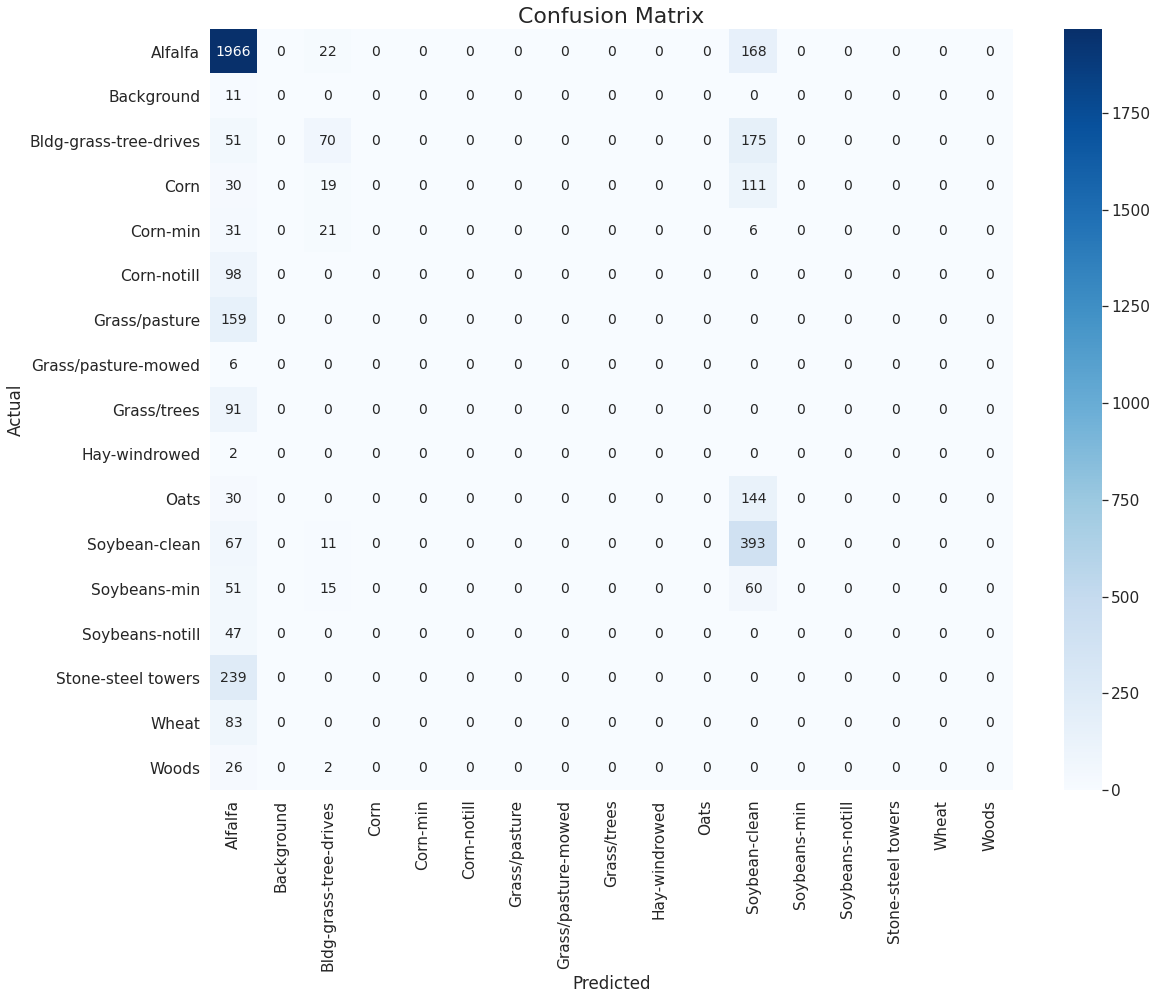

In [33]:
gt_color, gt_color_eventplot, indianpines_class_names = colors_names()
data = confusion_matrix(dataset_gt_test, dataset_gt_pred)
df_cm = pd.DataFrame(data, columns=np.unique(indianpines_class_names), index = np.unique(indianpines_class_names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (18,14))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 14}, fmt='d')
plt.title('Confusion Matrix', fontsize=22)
plt.savefig('Confusion Matrix SRP.TIF')